# Quickstart Guide: 

This Quickstart Guide presents a simple example of **ocean data challenge** for mapping the Sea Surface Height from sparse observations. 

The methodology is based on an Observing System Simulation Experiment (OSSE). The inputs data represent altimeter observations extracted from a realistic high-resolution ocean model simulation (NATL60). A simple mapping algorithm (Optimal Interpolation) is used to produce the reconstructed SSH field from the sparse observations. Finally, a comparison between the reconstructed and the reference SSH fields is done to quantify the reconstruction scores.

Three experiments are carried out: 
    
>   A) <font color=red> **Experiment 1**</font>: demo. of reconstruction with <font color=red> **1 nadir altimeter**</font>

>   B) <font color=blue> **Experiment 2**</font>: demo. of reconstruction with <font color=blue> **4 nadirs altimeter**</font>

>   C) <font color=grey> **Experiment 3**</font>: demo. of reconstruction with <font color=grey> **1 SWOT altimeter**</font>

The notebook is structured as follows:

    1) downloading the data
    2) Setup configuration of the interpolation
    3) Run the experiments
    4) Plot the reconstruction scores for each experiment

This quickstart guide take approx. 30 min to run on a PC. 

In [1]:
import xarray as xr
import numpy
import hvplot.xarray
import pyinterp
import dask
import warnings
import xrft
import logging
warnings.filterwarnings('ignore')

##### libraries versions

In [2]:
print('xarray', xr.__version__)
print('numpy', numpy.__version__)
print('hvplot', hvplot.__version__)
print('pyinterp', pyinterp.__version__)
print('dask', dask.__version__)
print('logging', logging.__version__)
print('xrft', xrft.__version__)

xarray 0.15.1
numpy 1.18.1
hvplot 0.6.0
pyinterp 0.3.1
dask 2.16.0
logging 0.5.1.2
xrft 0.2.0


In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)
client

<Client: 'tcp://127.0.0.1:57845' processes=4 threads=8, memory=17.04 GB>

In [5]:
from src.mod_oi import *
from src.mod_inout import *
from src.mod_regrid import *
from src.mod_eval import *
from src.mod_plot import *

### 1- DOWNLOADING DATA

##### Nature run SSH for mapping evaluation

In [6]:
%time
import gcsfs
fs = gcsfs.GCSFileSystem('pangeo-181919', requester_pays=True)
mapfilesref = fs.get_mapper('pangeo-meom/data-challenge-test/dc_ref')
dc_ref = xr.open_zarr(mapfilesref)

dc_ref

<xarray.Dataset>
Dimensions:   (lat: 600, lon: 600, time: 8760)
Coordinates:
  * lon       (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat       (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time      (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T23:30:00
Data variables:
    sossheig  (time, lat, lon) float32 dask.array<chunksize=(24, 600, 600), meta=np.ndarray>
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

##### Synthetic SSH observation for OI mapping

In [ ]:
!wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_data1/dc_obs_prep.tar.gz 

In [ ]:
!tar -xvf dc_obs_prep.tar.gz 

### 2- SETUP CONFIGURATION 

In [7]:
# OI Grid
lon_min = 295.
lon_max = 305.
lat_min = 33.
lat_max = 43.
time_min = numpy.datetime64('2012-10-22')
time_max = numpy.datetime64('2012-12-02')     
dx = 0.2                                                 # zonal grid spatial step (in degree)
dy = 0.2                                                 # meridional grid spatial step (in degree)
dt = numpy.timedelta64(1, 'D')                           # temporal grid step

simu_start_date = '2012-10-01T00:00:00'                  # Nature run initial date

glon = numpy.arange(lon_min, lon_max + dx, dx)
glat = numpy.arange(lat_min, lat_max + dy, dy)
gtime = numpy.arange(time_min, time_max + dt, dt)

# OI parameters
Lx = 1.            # Zonal decorrelation scale (in degree)
Ly = 1.            # Meridional decorrelation scale (in degree)
Lt = 7.            # Temporal decorrelation scale (in days)
noise = 0.05       # Noise level (5%)

### 3- RUN EXPERIMENTS

##### Select dc_ref sample

In [8]:
dc_ref_sample = dc_ref.sel(time=slice(time_min, time_max)).resample(time='1D').mean()
del dc_ref
dc_ref_sample

<xarray.Dataset>
Dimensions:   (lat: 600, lon: 600, time: 41)
Coordinates:
  * time      (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-01
  * lon       (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat       (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
Data variables:
    sossheig  (time, lat, lon) float32 dask.array<chunksize=(1, 600, 600), meta=np.ndarray>

##### Define input data observations for each experiment 

In [9]:
one_nadir = ['./dc_obs_prep/NATL60_jason1_2012-10-01_2013-09-29.nc']
four_nadirs = ['./dc_obs_prep/NATL60_jason1_2012-10-01_2013-09-29.nc', 
             './dc_obs_prep/NATL60_topex-poseidon_interleaved_2012-10-01_2013-09-29.nc',
             './dc_obs_prep/NATL60_envisat_2012-10-01_2013-09-30.nc',
             './dc_obs_prep/NATL60_geosat2_2012-10-01_2013-09-14.nc']
one_swot =  ['./dc_obs_prep/NATL60_karin_swot_2012-10-02_2013-09-30.nc', './dc_obs_prep/NATL60_nadir_swot_2012-10-03_2013-09-30.nc']

#### - EXP. 1: Demo. OI 1 nadir

In [10]:
%%time
# set OI param & grid
ds_oi1_param = oi_param(Lx, Ly, Lt, noise)
ds_oi1_grid = oi_grid(glon, glat, gtime, simu_start_date)
# Read input obs + discard a bit...
coarsening = {'time': 5}
ds_oi1_obs = read_obs(one_nadir, ds_oi1_grid, ds_oi1_param, simu_start_date, coarsening)
# Run OI
for it in range(len(gtime)):
    oi_core(it, ds_oi1_grid, ds_oi1_param, ds_oi1_obs)
# Regrid    
ds_oi1_regrid = oi_regrid(ds_oi1_grid, dc_ref_sample)
# Eval
rmse_t_oi1, rmse_xy_oi1 = rmse_based_scores(ds_oi1_regrid, dc_ref_sample)
psd_oi1 = psd_based_scores(ds_oi1_regrid, dc_ref_sample)

INFO:root:     Set OI params...
INFO:root:     Set OI grid...
INFO:root:     Reading observations...


INFO:root:     Regridding...
INFO:root:     Compute RMSE-based scores...
INFO:root:     Compute PSD-based scores...


Wall time: 47.1 s


#### - EXP. 2: Demo. OI 4 nadirs

In [11]:
%%time
# set OI param & grid
ds_oi2_param = oi_param(Lx, Ly, Lt, noise)
ds_oi2_grid = oi_grid(glon, glat, gtime, simu_start_date)
# Read input obs + discard a bit...
coarsening = {'time': 5}
ds_oi2_obs = read_obs(four_nadirs, ds_oi2_grid, ds_oi2_param, simu_start_date, coarsening)
# Run OI
for it in range(len(gtime)):
    oi_core(it, ds_oi2_grid, ds_oi2_param, ds_oi2_obs)
# Regrid    
ds_oi2_regrid = oi_regrid(ds_oi2_grid, dc_ref_sample)
# Eval
rmse_t_oi2, rmse_xy_oi2 = rmse_based_scores(ds_oi2_regrid, dc_ref_sample)
psd_oi2 = psd_based_scores(ds_oi2_regrid, dc_ref_sample)

INFO:root:     Set OI params...
INFO:root:     Set OI grid...
INFO:root:     Reading observations...


INFO:root:     Regridding...
INFO:root:     Compute RMSE-based scores...
INFO:root:     Compute PSD-based scores...


Wall time: 5min 41s


#### - EXP. 3: Demo. OI 1 swot

In [12]:
%%time
# set OI param & grid
ds_oi3_param = oi_param(Lx, Ly, Lt, noise)
ds_oi3_grid = oi_grid(glon, glat, gtime, simu_start_date)
# Read input obs + discard a bit...
coarsening = {'time': 15, 'nC': 6}
ds_oi3_obs = read_obs(one_swot[0], ds_oi3_grid, ds_oi3_param, simu_start_date, coarsening)
# Important line: vectorize for SWOT like data:
ds_oi3_obs = ds_oi3_obs.stack(z=('nC', 'time')).dropna(dim='z')
# Run OI
for it in range(len(gtime)):
    oi_core(it, ds_oi3_grid, ds_oi3_param, ds_oi3_obs)
# Regrid    
ds_oi3_regrid = oi_regrid(ds_oi3_grid, dc_ref_sample)
# Eval
rmse_t_oi3, rmse_xy_oi3 = rmse_based_scores(ds_oi3_regrid, dc_ref_sample)
psd_oi3 = psd_based_scores(ds_oi3_regrid, dc_ref_sample)

INFO:root:     Set OI params...
INFO:root:     Set OI grid...
INFO:root:     Reading observations...


INFO:root:     Regridding...
INFO:root:     Compute RMSE-based scores...
INFO:root:     Compute PSD-based scores...


Wall time: 15min 17s


#### - PLOT EVALUATION SCORES

In [13]:
rmse_concat = xr.concat((rmse_t_oi1, rmse_t_oi2, rmse_t_oi3), dim='experiment')
rmse_concat['experiment'] = ["1 nadir", "4 nadirs", "1 SWOT"]
rmse_concat.hvplot.line(x='time', y='rmse_t', by='experiment', ylim=(0, 1), cmap=['royalblue', 'orange', 'lightcoral'], title='RMSE-based scores')

:NdOverlay   [experiment]
   :Curve   [time]   (rmse_t)

The figure above represent the RMSE-based score timeseries for the SSH reconstruction with 1 nadir, with 4 nadirs and with 1 SWOT. Several conclusions can be drawn: a) better scaore is found in the reconstruction with 4 nadirs than with 1 nadir, b) reconstruction with 1 SWOT or with 4 nadir are relatively equivalent, c) the variability of the SWOT score is higher than with 4 nadir, directly linked to the spatio-temporal sampling of the observations (See figure below for the number of observation per reconstruction ady in the OI) 

In [14]:
nobs_concat = xr.concat((ds_oi1_grid.nobs, ds_oi2_grid.nobs, ds_oi3_grid.nobs), dim='experiment')
nobs_concat['experiment'] = ["1 nadir", "4 nadirs", "1 SWOT"]
nobs_concat.hvplot.bar(x='time', y='nobs', by='experiment', alpha=0.7, stacked=True, cmap=['orange', 'royalblue', 'lightcoral'], title='# obs in OI')

:Bars   [time,experiment]   (nobs)

In [15]:
rmse_xy_concat = xr.concat((rmse_xy_oi1, rmse_xy_oi2, rmse_xy_oi3), dim='experiment')
rmse_xy_concat['experiment'] = ["1 nadir", "4 nadirs", "1 SWOT"]
rmse_xy_concat.hvplot.contourf(x='lon', y='lat', levels=list(numpy.arange(0.,0.75, 0.05)), height=300, width=400, cmap='Reds', subplots=True, by='experiment', clabel='RMSE[m]')

:NdLayout   [experiment]
   :Polygons   [lon,lat]   (rmse_xy)

In [16]:
psd_concat = xr.concat((psd_oi1, psd_oi2, psd_oi3), dim='experiment')
psd_concat['experiment'] = ["1 nadir", "4 nadirs", "1 SWOT"]

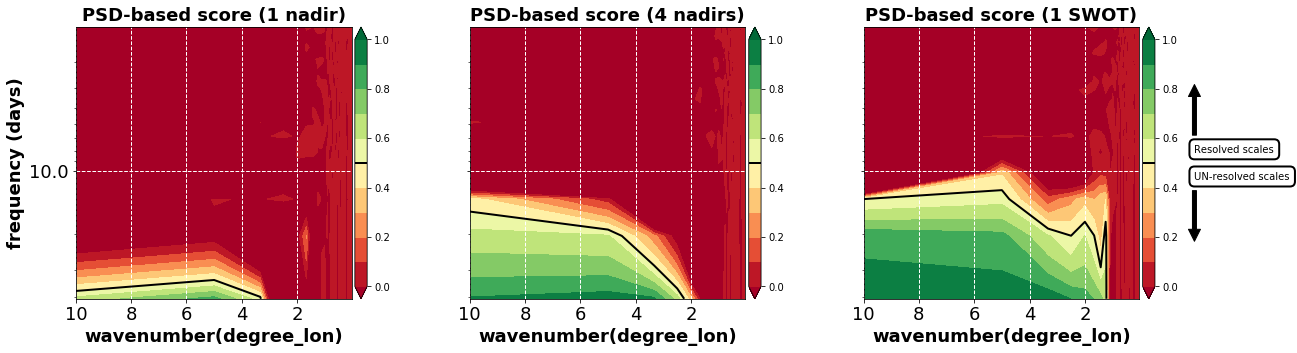

In [17]:
plot_psd_score(psd_concat)

The PSD-based score evaluates the spatio-temporal scales resolved in the mapping. The resolutions can be defined as the contour where the PSD-score = 0.5, black contour in the figure (i.e., the spatio-temporal scales where the reconstruction SSH error level is 2 times lower than the true SSH signal). The Figure above illustrates the spatio-temporal scales resolved in each experiment. It particularly shows the increase of resolving capability from 1 nadir to 1 SWOT altimeter.   